In [2]:
import matplotlib.pyplot as plt

import numpy as np

import json
import glob
import sys
import os

sys.path.append('../src')

### Visualization of training loss and test accuracy

In [3]:
with open('../experiments/history/history-AConvNet-SOC.json') as f:
    history = json.load(f)

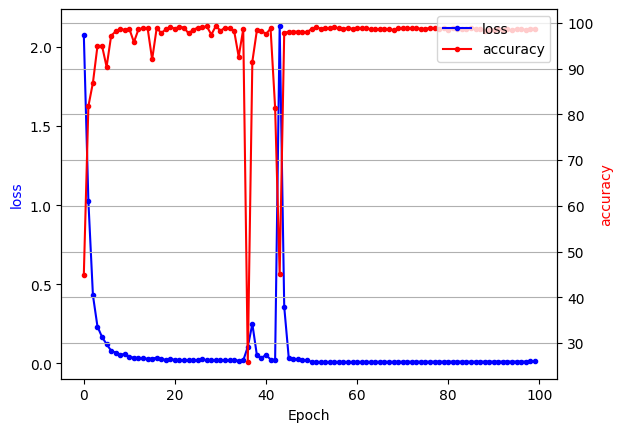

In [4]:
training_loss = history['loss']
test_accuracy = history['accuracy']

epochs = np.arange(len(training_loss))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plot1, = ax1.plot(epochs, training_loss, marker='.', c='blue', label='loss')
plot2, = ax2.plot(epochs, test_accuracy, marker='.', c='red', label='accuracy')
plt.legend([plot1, plot2], ['loss', 'accuracy'], loc='upper right')

plt.grid()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss', color='blue')
ax2.set_ylabel('accuracy', color='red')
plt.show()


### Early Stopping

In [5]:
from tqdm import tqdm
import torchvision
import torch

from utils import common
from data import preprocess
from data import loader
import model

In [6]:
def load_dataset(path, is_train, name, batch_size):

    _dataset = loader.Dataset(
        path, name=name, is_train=is_train,
        transform=torchvision.transforms.Compose([
            preprocess.CenterCrop(88), torchvision.transforms.ToTensor()
        ])
    )
    data_loader = torch.utils.data.DataLoader(
        _dataset, batch_size=batch_size, shuffle=is_train, num_workers=1
    )
    return data_loader


def evaluate(_m, ds):
    
    num_data = 0
    corrects = 0
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data

        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        num_data += labels.size(0)
        corrects += (predictions == labels.to(m.device)).sum().item()

    accuracy = 100 * corrects / num_data
    return accuracy

In [7]:

config = common.load_config(os.path.join(common.project_root, 'experiments/config/AConvNet-SOC.json'))
model_name = config['model_name']
test_set = load_dataset('dataset', False, 'soc', 100)

m = model.Model(
    classes=config['num_classes'], channels=config['channels'],
)

model_history = glob.glob(os.path.join(common.project_root, f'experiments/model/{model_name}/*.pth'))
model_history = sorted(model_history, key=os.path.basename)

best = {
    'epoch': 0,
    'accuracy': 0,
    'path': ''
}

for i, model_path in enumerate(model_history):
    m.load(model_path)
    accuracy = evaluate(m, test_set)
    if accuracy > best['accuracy']:
        best['epoch'] = i
        best['accuracy'] = accuracy
        best['path'] = model_path
        print(f'Best accuracy at epoch={i} with {accuracy:.2f}%')
    
best_epoch = best['epoch']
best_accuracy = best['accuracy']
best_path = best['path']

print(f'Final model is epoch={best_epoch} with accurayc={best_accuracy:.2f}%')
print(f'Path={best_path}')

load test data set: 2425it [00:00, 4423.24it/s]


Best accuracy at epoch=0 with 44.95%
Best accuracy at epoch=1 with 81.77%
Best accuracy at epoch=2 with 86.93%
Best accuracy at epoch=3 with 94.97%
Best accuracy at epoch=6 with 97.20%
Best accuracy at epoch=7 with 98.14%
Best accuracy at epoch=8 with 98.60%
Best accuracy at epoch=10 with 98.68%
Best accuracy at epoch=13 with 98.89%
Best accuracy at epoch=19 with 99.13%
Best accuracy at epoch=21 with 99.18%
Best accuracy at epoch=27 with 99.22%
Best accuracy at epoch=29 with 99.34%
Final model is epoch=29 with accurayc=99.34%
Path=/home/dzk/AConvNet-pytorch-main/experiments/model/AConvNet-SOC/model-030.pth


### Confusion Matrix with Best Model

In [8]:
print(best_path)
# best_path = "/home/dzk/AConvNet-pytorch-main/experiments/model/AConvNet-SOC/model-030.pth"
#best_path = "/home/dzk/AConvNet-pytorch-main/experiments/model/AConvNet-SOC/model-030.pth"

/home/dzk/AConvNet-pytorch-main/experiments/model/AConvNet-SOC/model-030.pth


In [25]:
from sklearn import metrics
from data import mstar
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def confusion_matrix(_m, ds):
    _pred = []
    _gt = []
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
        
        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        
        _pred += predictions.cpu().tolist()
        _gt += labels.cpu().tolist()
        
    conf_mat = metrics.confusion_matrix(_gt, _pred)
    # 计算精确度
    precision = precision_score(_gt, _pred, average='macro')

    # 计算召回率
    recall = recall_score(_gt, _pred, average='macro')

    # 计算F1分数
    f1 = f1_score(_gt, _pred, average='macro')    
    return conf_mat, precision, recall, f1

In [26]:
m.load(best_path)
_conf_mat, precision, recall, f1 = confusion_matrix(m, test_set)

In [28]:
print(precision),print(recall),print(f1)

0.9926174284513811
0.9923941491251188
0.9924703368690049


(None, None, None)

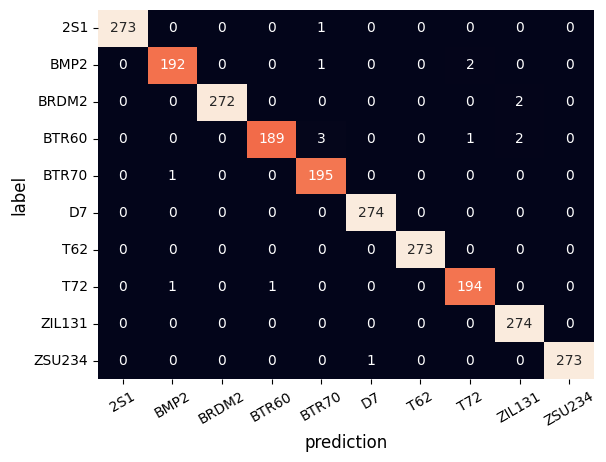

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

m.load(best_path)
_conf_mat = confusion_matrix(m, test_set)



sns.reset_defaults()
ax = sns.heatmap(_conf_mat, annot=True, fmt='d', cbar=False)
ax.set_yticklabels(mstar.target_name_soc, rotation=0)
ax.set_xticklabels(mstar.target_name_soc, rotation=30)

plt.xlabel('prediction', fontsize=12)
plt.ylabel('label', fontsize=12)


plt.show()

In [12]:
print(type(_conf_mat)), print(_conf_mat)

<class 'numpy.ndarray'>
[[273   0   0   0   1   0   0   0   0   0]
 [  0 192   0   0   1   0   0   2   0   0]
 [  0   0 272   0   0   0   0   0   2   0]
 [  0   0   0 189   3   0   0   1   2   0]
 [  0   1   0   0 195   0   0   0   0   0]
 [  0   0   0   0   0 274   0   0   0   0]
 [  0   0   0   0   0   0 273   0   0   0]
 [  0   1   0   1   0   0   0 194   0   0]
 [  0   0   0   0   0   0   0   0 274   0]
 [  0   0   0   0   0   1   0   0   0 273]]


(None, None)

In [29]:
def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fn = np.sum(confusion_matrix[i, :]) - tp
        fp = np.sum(confusion_matrix[:, i]) - tp

        precision[i] = tp / (tp + fp)
        recall[i] = tp / (tp + fn)
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    return precision, recall, f1_score

In [30]:
precision, recall, f1_score = calculate_metrics(_conf_mat)

In [31]:
# 打印结果
for i in range(len(precision)):
    print(f"Class {i+1}: Precision = {precision[i]}, Recall = {recall[i]}, F1 Score = {f1_score[i]}")

Class 1: Precision = 1.0, Recall = 0.9963503649635036, F1 Score = 0.9981718464351006
Class 2: Precision = 0.9896907216494846, Recall = 0.9846153846153847, F1 Score = 0.9871465295629821
Class 3: Precision = 1.0, Recall = 0.9927007299270073, F1 Score = 0.9963369963369962
Class 4: Precision = 0.9947368421052631, Recall = 0.9692307692307692, F1 Score = 0.9818181818181819
Class 5: Precision = 0.975, Recall = 0.9948979591836735, F1 Score = 0.984848484848485
Class 6: Precision = 0.9963636363636363, Recall = 1.0, F1 Score = 0.9981785063752276
Class 7: Precision = 1.0, Recall = 1.0, F1 Score = 1.0
Class 8: Precision = 0.9847715736040609, Recall = 0.9897959183673469, F1 Score = 0.9872773536895675
Class 9: Precision = 0.9856115107913669, Recall = 1.0, F1 Score = 0.9927536231884058
Class 10: Precision = 1.0, Recall = 0.9963503649635036, F1 Score = 0.9981718464351006


### Noise Simulation

In [19]:
from skimage import util


def generate_noise(_images, amount):
    
    n, _, h, w = _images.shape
    # print("n = ", n , "h = ", h, "w = " , w, "amount = ", amount)
    noise = np.array([np.random.uniform(size=(1, h, w)) for _ in range(n)])
    portions = np.array([
        util.random_noise(np.zeros((1, h, w)), mode='s&p', amount=amount)
        for _ in range(n)
    ])
    noise = noise * portions
        
    return _images + noise.astype(np.float32)


def noise_simulation(_m, ds, noise_ratio):
    
    num_data = 0
    corrects = 0
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
        images = generate_noise(images, noise_ratio)

        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        num_data += labels.size(0)
        corrects += (predictions == labels.to(m.device)).sum().item()

    accuracy = 100 * corrects / num_data
    
    return accuracy

In [22]:
noise_result = {}

for ratio in [0.01, 0.05, 0.10, 0.15]:
    noise_result[ratio] = noise_simulation(m, test_set, ratio)
    print(f'ratio = {ratio:.2f}, accuracy = {noise_result[ratio]:.2f}')


ratio = 0.01, accuracy = 98.72
ratio = 0.05, accuracy = 94.19
ratio = 0.10, accuracy = 83.38
ratio = 0.15, accuracy = 70.27


### EOC-1 Result with SOC Model

In [11]:
def evaluate_eoc_1(_m, ds):
    
    label_map = [0, 2, 7, 9]
    
    num_data = 0
    corrects = 0
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
        labels = [label_map[c] for c in labels]

        predictions = _m.inference(images)
        predictions = _softmax(predictions)
        
        _, predictions = torch.max(predictions.data, 1)
        labels = torch.LongTensor(labels)
        
        num_data += labels.size(0)
        corrects += (predictions == labels.to(m.device)).sum().item()

    accuracy = 100 * corrects / num_data
    return accuracy


def confusion_matrix(_m, ds):
    _pred = []
    _gt = []
    
    pred_map = [0, 4, 1, 5, 6, 7,  8, 2, 9, 3]
        
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
                
        predictions = _m.inference(images)
        predictions = _softmax(predictions)
        
        _, predictions = torch.max(predictions.data, 1)
        predictions = [pred_map[c] for c in predictions] 
        labels = labels.type(torch.LongTensor)
                
        _pred += predictions
        _gt += labels.cpu().tolist()
        
    conf_mat = metrics.confusion_matrix(_gt, _pred, labels=range(10))
        
    return conf_mat

In [12]:
eoc_test_set = load_dataset('dataset', False, 'eoc-1-t72-132', 100)
accuracy = evaluate_eoc_1(m, eoc_test_set)
print(accuracy)

load test data set: 1151it [00:00, 2004.00it/s]


60.382276281494356


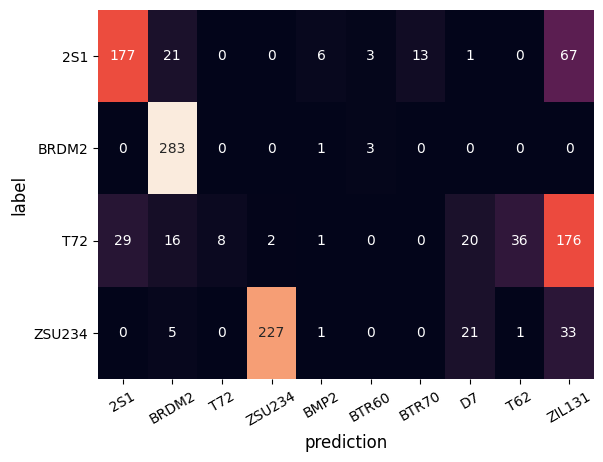

In [13]:

target_name_soc_eoc1 = ('2S1', 'BRDM2', 'T72', 'ZSU234', 'BMP2', 'BTR60', 'BTR70', 'D7', 'T62',  'ZIL131')
_conf_mat = confusion_matrix(m, eoc_test_set)

sns.reset_defaults()
ax = sns.heatmap(_conf_mat[:4, :], annot=True, fmt='d', cbar=False)
ax.set_yticklabels(mstar.target_name_eoc_1, rotation=0)
ax.set_xticklabels(target_name_soc_eoc1, rotation=30)

plt.xlabel('prediction', fontsize=12)
plt.ylabel('label', fontsize=12)


plt.show()

### EOC-2 Configuration Variant Result with SOC Model

In [14]:
def evaluate_eoc_2(_m, ds):
    
    label_map = [1, 2, 4, 7]
    
    num_data = 0
    corrects = 0
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
        labels = [label_map[c] for c in labels]

        predictions = _m.inference(images)
        predictions = _softmax(predictions)
        
        _, predictions = torch.max(predictions.data, 1)
        labels = torch.LongTensor(labels)
        
        num_data += labels.size(0)
        corrects += (predictions == labels.to(m.device)).sum().item()

    accuracy = 100 * corrects / num_data
    return accuracy


def confusion_matrix(_m, ds):
    _pred = []
    _gt = []
    
    pred_map = [4, 0, 1, 5, 2, 6, 7, 3, 8, 9]
        
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
        
        predictions = _m.inference(images)
        predictions = _softmax(predictions)
        
        _, predictions = torch.max(predictions.data, 1)
        predictions = [pred_map[c] for c in predictions] 
        labels = labels.type(torch.LongTensor)
                
        _pred += predictions
        _gt += labels.cpu().tolist()
    
    conf_mat = metrics.confusion_matrix(_gt, _pred, labels=range(10))
        
    return conf_mat

In [15]:
eoc_test_set = load_dataset('dataset', False, 'eoc-2-cv', 100)
accuracy = evaluate_eoc_2(m, eoc_test_set)
print(accuracy)

load test data set: 2710it [00:01, 2046.83it/s]


47.7859778597786


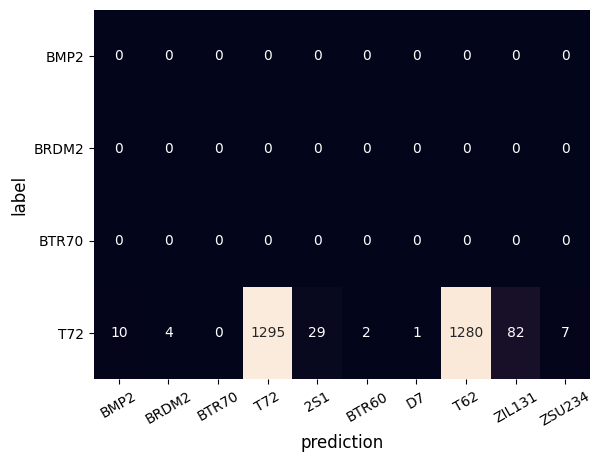

In [16]:

target_name_soc_eoc2 = ('BMP2', 'BRDM2', 'BTR70', 'T72', '2S1',  'BTR60', 'D7', 'T62', 'ZIL131', 'ZSU234')
_conf_mat = confusion_matrix(m, eoc_test_set)


sns.reset_defaults()
ax = sns.heatmap(_conf_mat[:4, :], annot=True, fmt='d', cbar=False)
ax.set_yticklabels(mstar.target_name_eoc_2, rotation=0)
ax.set_xticklabels(target_name_soc_eoc2, rotation=30)

plt.xlabel('prediction', fontsize=12)
plt.ylabel('label', fontsize=12)


plt.show()